# Принятие решений в бизнесе на основе данных. Проект.

## Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import date, time, timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
# забираю таблицы
try:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv', parse_dates=['date']),
    pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])
)
    
except:
    hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),
    pd.read_csv('orders.csv', parse_dates=['date']),
    pd.read_csv('visitors.csv', parse_dates=['date'])
)

In [3]:
def get_info(df):
    display(df.info(), df.head(3), df.isnull().sum(), df.duplicated().sum())

df_list = [hypothesis, orders, visitors]
for i in df_list: 
    get_info(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


date        0
group       0
visitors    0
dtype: int64

0

In [4]:
# работаю с названиями колонок
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={"transactionId": "transaction_id", "visitorId": "visitor_id"})

# меняю типы данных
orders['transaction_id'] = orders['transaction_id'].astype(str)
orders['visitor_id'] = orders['visitor_id'].astype(str)

## Приоритизация гипотез

### Применение фреймворка ICE

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач:

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [5]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending=False)[['hypothesis','ICE']].head()

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00


### Применение фреймворка RICE

У этого метода есть модификация RICE (R от англ. reach, «охват»):

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [6]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending=False)[['hypothesis','RICE']].head()

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.00
2,Добавить блоки рекомендаций товаров на сайт ин...,56.00
0,"Добавить два новых канала привлечения трафика,...",40.00
6,Показать на главной странице баннеры с актуаль...,40.00
8,"Запустить акцию, дающую скидку на товар в день...",16.20


После применения фреймворка `RICE`, топ гипотез, которые следует взять в работу - изменился. Это произошло из-за того, что в формулу добавили расчет от `Reach`. Теперь чем больше пользователей затронет изменение - тем больше пойнтов получает гипотеза, ну а в фреймворке `ICE` мы этого не считаем.

## Анализ A/B-теста

### Сбор кумулятивных данных

In [7]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [8]:
# получим агрегированные кумулятивные по дням данные о заказах
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
        .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
        .sort_values(by=['date','group'])
)

In [9]:
# получим агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],visitors['group'] == x['group'])]
        .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
        .sort_values(by=['date','group'])
)

In [10]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


### График кумулятивной выручки по группам

In [11]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

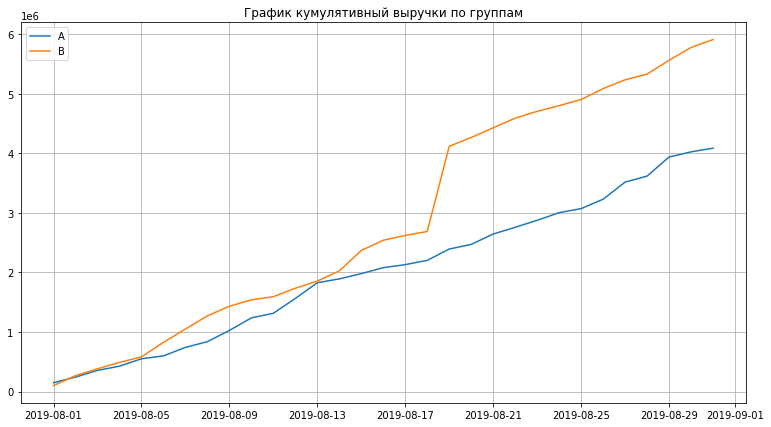

In [12]:
# Строим график выручки группы А
plt.figure(figsize=(13,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивный выручки по группам')
plt.grid()
plt.legend()
plt.show()

У обоих групп выручка увеличивается в течении всего теста, это хороший знак. Но у группы `B` во второй половине теста выручка сделала резкий рывок вверх. Возможно пришел кит и заплатил большую сумму.

### График кумулятивного среднего чека по группам

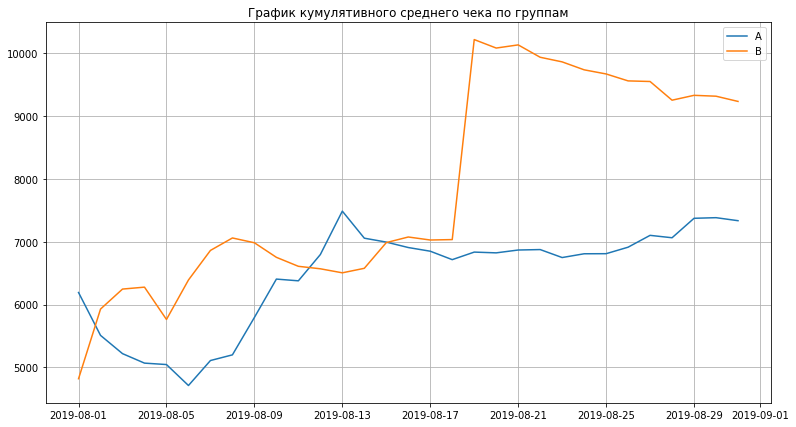

In [13]:
plt.figure(figsize=(13,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.grid()
plt.legend()
plt.show()

В первой половине теста обе группы держаться примерно на равных значениях средних чеков, но вот во второй половине группа `B` резко выбивается вперед.

### График относительного изменения кумулятивного среднего чека группы B к группе A

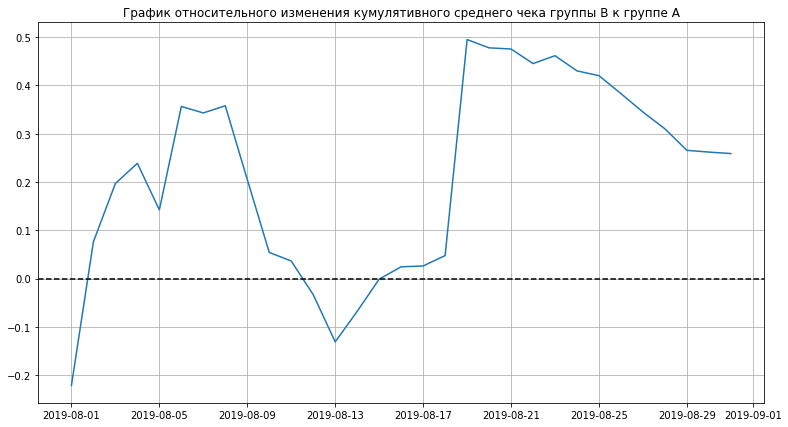

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(13,7))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.grid()
plt.show()

Группа `B` в первое время ходила волнами, но во второй половине теста резко подскочила вверх и зафиксировалась там.

### График кумулятивной конверсии по группам

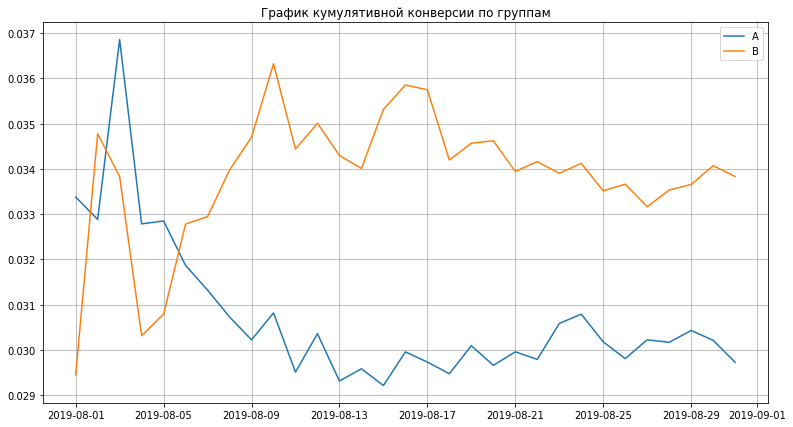

In [15]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(13,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.grid()
plt.show()

Конверсия у обоих групп колебалась в начале эксперимента, но потом конверсия группы `B` резко вырвалась вперед и зафиксировалась, а у группы `A` наоборот, упала.

### График относительного изменения кумулятивной конверсии группы B к группе A

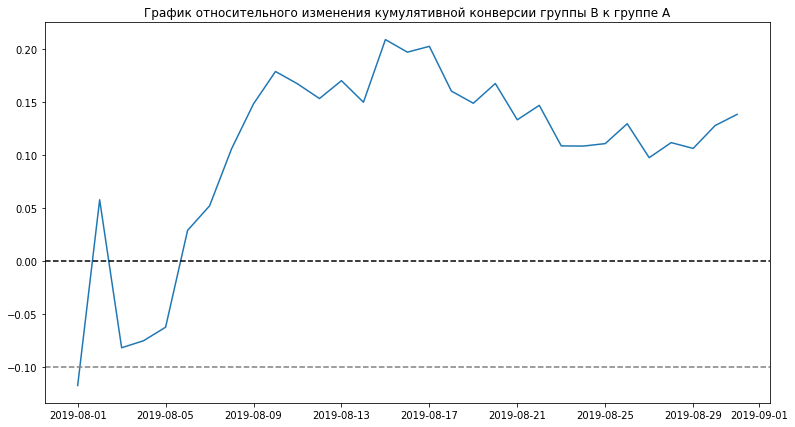

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(13,7))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.show()

Группа `B` почти с самого начала эксперимента резко вырвалась вперед и сильно держит свои позиции.

### Точечные графики количества/стоимости заказов по пользователям

In [17]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)
ordersByUsers.columns = ['visitor_id','orders']

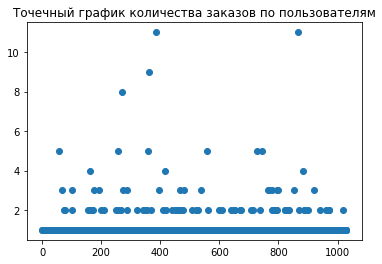

In [18]:
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Точечный график количества заказов по пользователям')
plt.show()

По графику видно, что есть весьма "дорогие" заказы.

In [19]:
# Считаю 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Если отсеивать 5% данных, то надо будет отсеить начиная с двух заказов.

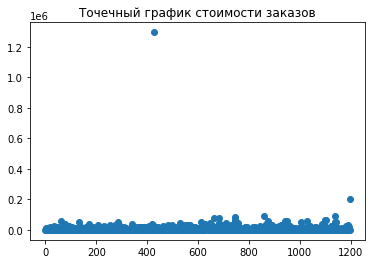

In [20]:
# scatter график стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимости заказов')
plt.show()

Есть 2 очень дорогих заказов. Попробуем убрать их.

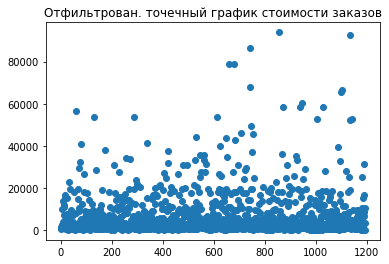

In [21]:
orders2 = orders.query('revenue < 200000')
x_values = pd.Series(range(0,len(orders2['revenue'])))
plt.scatter(x_values, orders2['revenue'])
plt.title('Отфильтрован. точечный график стоимости заказов')
plt.show()

In [22]:
# Считаю 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Если отсеивать 5% данных, то надо будет отсеить начиная со стоимости 28000

### Статистическая значимость различий конверсии и среднего чека. Неочищенные данные.

In [23]:
# подготавливаю данные для анализа

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Сформируем гипотезы:
1. Конверсия по неочищенным данным:  
`Нулевая гипотеза` – конверсия у групп A и B не отличается <br>
`Альтернативная гипотеза` – конверсия у групп A и B отличается 

2. Средний чек по неочищенным данным:  
`Нулевая гипотеза` – средний чек у групп A и B не отличается<br>
`Альтернативная гипотеза` – средний чек у групп A и B отличается

In [24]:
# Считаю статистическую значимость различия в конверсии между группами по сырым данным

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.4f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.4f}".format(sampleB.mean() / sampleA.mean() - 1))

0.0168
0.1381


Вывод: По «сырым» данным различия в конверсии у групп `A и B` есть.
Первое число — p-value = 0.0084 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.

In [25]:
# гляну на  относительные различия в среднем чеке между группами
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

### Статистическая значимость различий конверсии и среднего чека. Очищенные данные.

Сформируем гипотезы:
1. Конверсия по очищенным данным:  
`Нулевая гипотеза` – конверсия у групп A и B не отличается <br>
`Альтернативная гипотеза` – конверсия у групп A и B отличается 

2. Средний чек по очищенным данным:  
`Нулевая гипотеза` – средний чек у групп A и B не отличается<br>
`Альтернативная гипотеза` – средний чек у групп A и B отличается

Попробуем посмотреть на данные через очищен. данные.
Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 4% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [26]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1103    1164614297
31      1230306981
1136    1307669133
858     1316129916
421     1357170471
Name: visitor_id, dtype: object
(68,)


Всего 68 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [27]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [28]:
print('{0:.4f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]))
print('{0:.4f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.0133
0.1716


Результаты по конверсии практически не изменились. Произошло ли что-нибудь с результатами по среднему чеку?

In [29]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.720
-0.023


Интересно, но после удаления выбросов средний чек у групп не различается. P-value значительно больше 0.05. Значит отвергаем нулевую гипотезу.

Имеющиеся факты:
1. Нет статистически значимого различия по конверсии между группами ни по «сырым», ни по данным после фильтрации аномалий.
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
3. График различия конверсии между группами сообщает, что результаты группы `A` хуже группы `B` и нет значительной тенденции к улучшению.
4. График различия среднего чека говорит о том, что результаты группы `A` хуже результатов `B`, но только когда данные не очищены. После удаления выбросов средний чек у групп не различается.

## Вывод

После анализа и имеющихся фактов, хочу поздравить всю команду с успешно проведенем тестом. Мы молодцы! Ведь мы провели удачный эксперимент и успешно смогли поднять монетиз. метрики нашего проекта :)
<br> <br> А теперь по тесту: советую остановить тест и признать его успешным. Победили изменения сделанные в `группе B`.
1. Конверсия у группы `B` выше примерно на 15%, чем у группы `A`. (как с выбросами так и без)
2. По неочищен. данным средний чек у группы `B` тоже заметно выше `A`, но если убрать выбросы - средний чек у групп не отличается.

Советую раскатить изменения `B` на 100% и начать прорабатывать новую гипотезу.